# Financial Mathematics : Final Assignment

## Libraries imports

In [37]:
import warnings
#To ignore all the warning messages
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math

# Keras imports
from keras.models import Sequential
from keras.layers import Dense

from keras.layers import LSTM
plt.style.use('seaborn')

## Dataset Loading

### 2. Make a new dataframe with only the columns: Open, High, Low, and Close. Use this dataframe as your dataset for the remaining tasks below.

In [38]:
# Read in the data using Pandas
dataframe = pd.read_csv('HKXCY.csv', engine= 'python', sep=',')

#Dropping unnecessary columns from the dataframe
dataframe.drop(['Date', 'Adj Close', 'Volume'], axis=1, inplace=True)

# Store the dataset into a numpy array
dataset = dataframe.values.astype('float64')

### Data visualization

In [39]:
dataset.shape

(251, 4)

In [40]:
dataframe.head()

Open       High        Low      Close
0  31.680000  32.099998  31.680000  32.099998
1  32.150002  32.150002  32.009998  32.099998
2  32.980000  32.980000  32.650002  32.820000
3  32.990002  32.990002  32.520000  32.590000
4  33.410000  33.770000  33.360001  33.669998

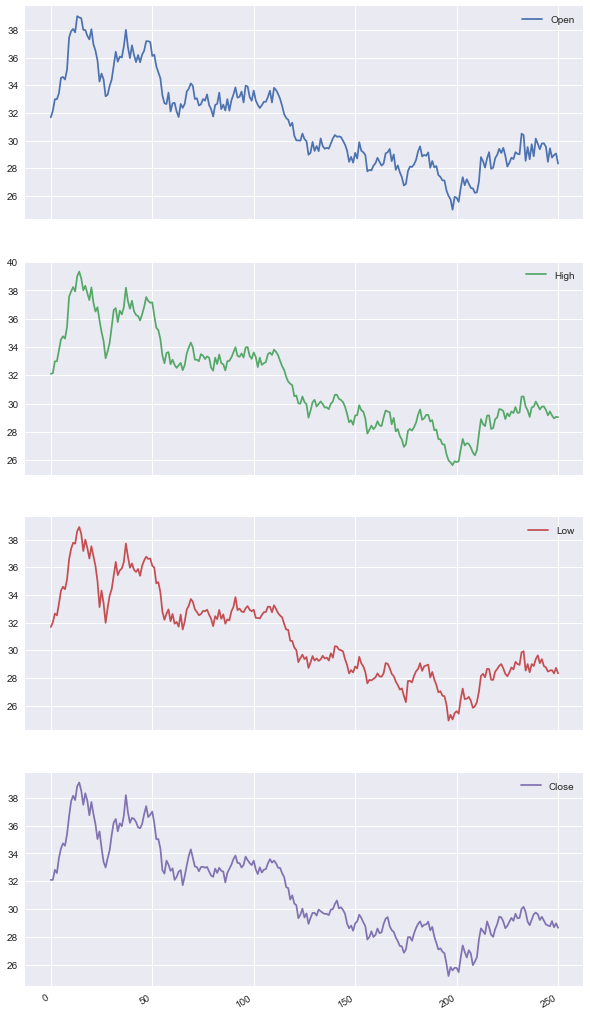

In [41]:
dataframe.plot(figsize=(10,20),subplots=True)
plt.show()

## Normalisation of the data

### 3. Use ScikitLearn’s MinMaxScaler() function to normalise your data to be between -1 and 1

In [42]:
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset = scaler.fit_transform(dataset)

In [43]:
dataset[0:5]

array([[-0.0450323 , -0.05632802, -0.03290429, -0.00647984],
       [ 0.02215882, -0.04901214,  0.01430572, -0.00647984],
       [ 0.1408147 ,  0.07242136,  0.10586565,  0.09719216],
       [ 0.14224458,  0.07388471,  0.08726737,  0.06407481],
       [ 0.20228718,  0.18800293,  0.20743917,  0.21958209]])

## Train and Test Split

### 4. Split your data into training and testing at a proportion of your choice. Justify why you used such a proportion.

I have used 70 % of the data for training and 30 % for testing.

By having in mind that the training data should be greater than 50 % and the testing data should not be smaller than 10%, I did this choice because of the size of data which is only 251, so for a good learning process in this case 70 % of the data for training and 30 % for testing is a good choice according also to the result that i got.

In [44]:
# Amount of data that will be used for training.
train_size = int(len(dataset) * 0.7)

# Amount of data that will be used for testing.
test_size = len(dataset) - train_size

# Split the data manually.
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

## Create labels for the dataset

### 5. Using a rolling window (look-back) of 10, create a labelled training and testing sets, and reshape these sets to have the format the sizes of [samples, timesteps, features].

In [45]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    return np.array(dataX), np.array(dataY)

In [46]:
look_back = 10

# Split the data into training features and training targets
trainX, trainY = create_dataset(train, look_back)

# Split the data into testing features and testing targets
testX, testY = create_dataset(test, look_back)

#### Reshape to [samples, timesteps, features]

In [47]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 4))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 4))

In [48]:
print('Train X shape ',trainX.shape)
print('Train Y shape',trainY.shape)
print('Test X shape ',testX.shape)
print('Test Y shape ',testY.shape)

Train X shape  (164, 10, 4)
Train Y shape (164, 4)
Test X shape  (65, 10, 4)
Test Y shape  (65, 4)


## Creation of a statefull LSTM model

In [49]:
# Define the model in Keras
model = Sequential()
# Add an LSTM cell
model.add(LSTM(16, batch_input_shape=(1, look_back, 4), stateful=True))
model.add(Dense(4))
model.compile(loss='mean_squared_error', optimizer='adam')

In [50]:
# look at the model from Keras' point of view
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (1, 16)                   1344      
_________________________________________________________________
dense_3 (Dense)              (1, 4)                    68        
Total params: 1,412
Trainable params: 1,412
Non-trainable params: 0
_________________________________________________________________


## Training of the model

### 6. Train and test a Stateful LSTM model. State your final training and testing losses.

In [51]:
for i in range(40):
    model.fit(trainX, trainY, epochs=1, batch_size=1, verbose=0, shuffle=False)
    model.reset_states()

### Final Losses (MSE)

In [52]:
trainScore = model.evaluate(trainX, trainY, batch_size=1, verbose=0)
model.reset_states()
print("Loss(training data ): %.4f"%trainScore)

Loss(training data ): 0.0072


In [53]:
testScore = model.evaluate(testX, testY, batch_size=1, verbose=0)
model.reset_states()
print("Loss(test data ): %.4f"%testScore)

Loss(test data ): 0.0062


## Predictions 

In [54]:
# generate predictions for training
trainPredict = model.predict(trainX, batch_size=1)
testPredict = model.predict(testX, batch_size=1)
trainPredictPlot = trainPredict
testPredictPlot = testPredict

## Plots

### 7. Super-imposed on each other, plot the training, the predictions on the training, the testing and the predictions on the testing data in one figure.

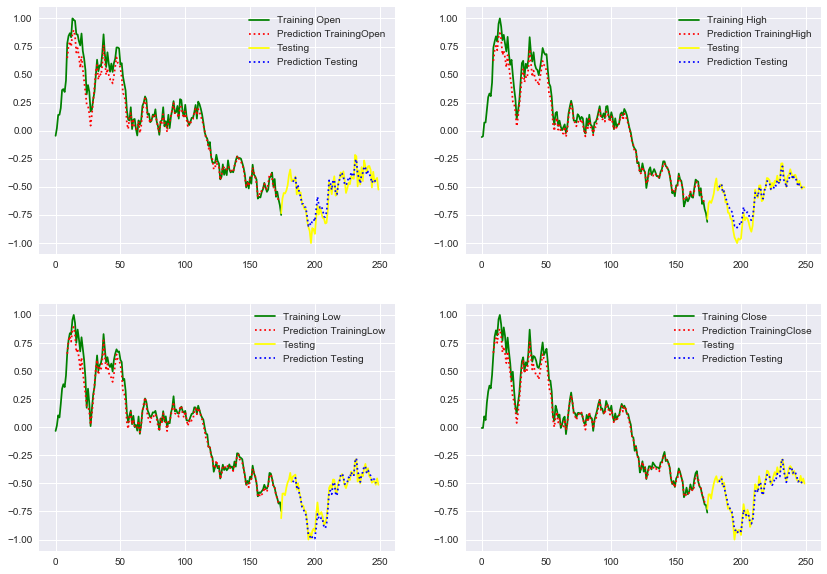

In [55]:

_,axes=plt.subplots(ncols=2,nrows=2,figsize=(14,10))

i=0
for k in range(2):
    for j in range(2):
        axes[k,j].plot(train[:,i], label='Training '+dataframe.columns[i], color='green')
        inf_lim=look_back-1
        sup_lim=len(trainPredictPlot[:,i])+inf_lim
        axes[k,j].plot([i for i in range(inf_lim,sup_lim)],trainPredictPlot[:,i], label='Prediction Training'+dataframe.columns[i], linestyle='dotted', color='red')
        inf_lim=sup_lim+1
        sup_lim=inf_lim+len(test)
        axes[k,j].plot([i for i in range(inf_lim,sup_lim)],test[:,i], label='Testing', color='yellow')
        inf_lim=inf_lim +look_back-1
        sup_lim=sup_lim-2
        axes[k,j].plot([i for i in range(inf_lim,sup_lim)],testPredictPlot[:,i], label='Prediction Testing', linestyle='dotted', color='blue')
        axes[k,j].legend()
        i+=1

plt.show()

## Bonus Points

### 8. (Bonus points) Repeat 7 using the actual prices of the stock instead of the normalised values used in 7 above.

In [56]:
train_s_inv = scaler.inverse_transform(train)
test_s_inv = scaler.inverse_transform(test)
trainPredict_s_i = scaler.inverse_transform(trainPredictPlot)
testPredict_s_i = scaler.inverse_transform(testPredictPlot)

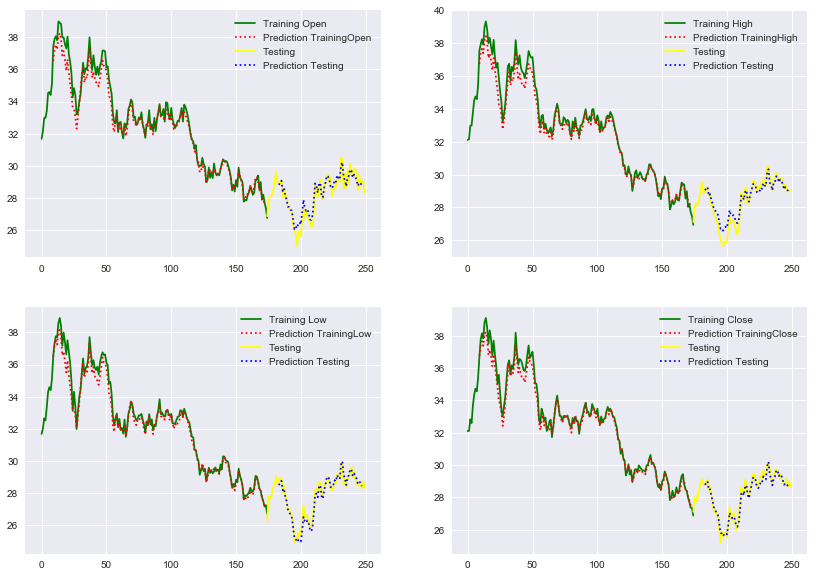

In [57]:
_,axes=plt.subplots(ncols=2,nrows=2,figsize=(14,10))

i=0
for k in range(2):
    for j in range(2):
        axes[k,j].plot(train_s_inv[:,i], label='Training '+dataframe.columns[i], color='green')
        inf_lim=look_back-1
        sup_lim=len(trainPredictPlot[:,i])+inf_lim
        axes[k,j].plot([i for i in range(inf_lim,sup_lim)],trainPredict_s_i[:,i], label='Prediction Training'+dataframe.columns[i], linestyle='dotted', color='red')
        inf_lim=sup_lim+1
        sup_lim=inf_lim+len(test)
        axes[k,j].plot([i for i in range(inf_lim,sup_lim)],test_s_inv[:,i], label='Testing', color='yellow')
        inf_lim=inf_lim +look_back-1
        sup_lim=sup_lim-2
        axes[k,j].plot([i for i in range(inf_lim,sup_lim)],testPredict_s_i[:,i], label='Prediction Testing', linestyle='dotted', color='blue')
        axes[k,j].legend()
        i+=1

plt.show()